In [1]:
import components
import pandas as pd
import numpy as np
path_results = "results/"

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [2]:
# simulation broker
path_Sim = "test_data/beam1/beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
SimBroker = components.SimBroker(path_Sim, dtype_Sim)

# vehicle generator
path_DataBase = "test_data/vehicleFiles/vehicletypes-Base_2035_20210204_updated.csv"
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)

path_save = path_results+"sim1"
ResultWriter = components.ResultWriter(path_save)

In [3]:
# show head of vehicles dataframe
VehicleGenerator.vehicles.head(3)

,vehicleType
vehicle,
2517,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
9368,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
11104,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC


#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [4]:
# load infrastructure file into dataframe
path_infrastructure = "test_data/beam1/gemini-base-scenario-3-charging-no-household-infra16.csv"
usecols_infrastructure = ["taz", "parkingType", "chargingPointType", "parkingZoneId"]
dtype_infrastructure = {"taz": "int64", "parkingType": "category", "chargingPointType": "category", "parkingZoneId": "string"}
infrastructure = pd.read_csv(path_infrastructure, dtype=dtype_infrastructure, usecols=usecols_infrastructure)
infrastructure = infrastructure.set_index("parkingZoneId")
# filter infrastructure for only public fast and extreme fast charging
infrastructure = infrastructure.loc[infrastructure["parkingType"] == "Public"]
infrastructure = infrastructure.loc[infrastructure["chargingPointType"].str.contains("publicfc|publicxfc")]
infrastructure = infrastructure.sort_values(by = ["taz", "parkingZoneId"])

#now, make a dict of every parkingZoneId that belongs to a charging station
# here, we will split the chargingstation
chargingStationMappedToParkingZoneId = {}
chargingStationMappedToTaz = {}
stepsize = 200
i = 0 
j = 1
stop = False
while i < len(infrastructure) -1 :
    name = "chargingStation-" + str(j)
    # we want to make sure, that all the chargingBays of one TAZ are in one chargingStation
    if i + stepsize < len(infrastructure) :
        i_end = i+stepsize
        while infrastructure.iloc[i_end]["taz"] == infrastructure.iloc[i_end+1]["taz"]:
            i_end +=1 # if the taz is the same, we should increase reading to that taz
            if i_end +1 >= len(infrastructure) - 1 : # make sure, that we don't try to read in the next step something that doesnt exist
                stop = True
                break
    else: 
        i_end = len(infrastructure)-1
    if not stop:
        i_end += 1 # to also catch the last element
    slice = infrastructure.iloc[i:i_end]
    chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
    chargingStationMappedToTaz[name] = list(set(slice["taz"].to_list())) # this removes duplicates
    i = i_end # start reading next cycle at i
    j += 1

# we convert chargingStationMappedToTaz to a dataframe to use search methods
chargingStationMappedToTaz = pd.DataFrame.from_dict(chargingStationMappedToTaz, orient='index')
chargingStationMappedToTaz = chargingStationMappedToTaz.transpose()

# #here, we will make chargingStation depending on TAZ. Therefore, get a list of the different TAZ and sort it:
# taz = infrastructure.taz.drop_duplicates().to_list()
# taz = sorted(taz)
# while i < len(taz):
#     name = "chargingStation-" + str(j)
#     # slice = infrastructure.loc[infrastructure["taz"].isin(taz[i:i+stepsize])]
#     chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
#     i += stepsize
#     j += 1

In [5]:
infrastructure.head(3)

,taz,parkingType,chargingPointType
parkingZoneId,,,
X-PEV-9-1,9,Public,publicfc(150.0|DC)
X-PEV-11-1,11,Public,publicfc(150.0|DC)
X-PEV-12-1,12,Public,publicfc(150.0|DC)


In [6]:
print(chargingStationMappedToParkingZoneId.keys())

dict_keys(['chargingStation-1', 'chargingStation-2', 'chargingStation-3'])


In [7]:
#create chargingStations
chargingStations = [] # list of charging stations
for i in chargingStationMappedToParkingZoneId:
    #chargingStations.append(i)

    ChargingStationId = i
    ChBaNum = len(chargingStationMappedToParkingZoneId[i])
    # make a list with the powers of the bays:
    ChBaMaxPower = []
    for j in chargingStationMappedToParkingZoneId[i]:
        power_string = infrastructure.loc[j, "chargingPointType"]
        ChBaMaxPower.append(components.chargingCapFromString(power_string))
    # for now, we assume that all charging bays have the same charging power
    PowerMax = max(ChBaMaxPower)
    len_power = len(ChBaMaxPower)
    ChBaMaxPower = []
    for j in range(0, len_power):
        ChBaMaxPower.append(PowerMax)
    del PowerMax, len_power
    
    ChBaParkingZoneId = chargingStationMappedToParkingZoneId[i]
    calcBtmsGridProp = True

    # think about variable power limits
    # include interfaces like in diagram

    
    container = components.ChaDepLimCon(ChargingStationId=ChargingStationId, ResultWriter=ResultWriter, SimBroker = SimBroker, ChBaMaxPower=ChBaMaxPower, ChBaParkingZoneId=ChBaParkingZoneId, calcBtmsGridProp = True)
    chargingStations.append(container)
    print(ChargingStationId + " was created with " + str(container.ChBaNum) + " charging bays and " + str(container.BtmsSize) + "kWh BTM-Storage")

chargingStation-1 was created with 208 charging bays and 26000.0kWh BTM-Storage
chargingStation-2 was created with 207 charging bays and 25875.0kWh BTM-Storage
chargingStation-3 was created with 93 charging bays and 11625.0kWh BTM-Storage


- initialize helper objects for simulation input

In [8]:
PhySimDummy = components.PhySimDummy(chargingStations)
DermsDummy  = components.DermsDummy(chargingStations)

#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [9]:
for x in chargingStations:
    GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
    x.initialize(GridPowerLower = GridPowerLower, GridPowerUpper = GridPowerUpper)

#### run simulation

In [10]:
'''Simulation settings:'''
timestep = 5 * 60

In [11]:
SimBroker.reset()
ResultWriter.reset()
# charging station is not resetted

iteration = 0

while not SimBroker.eol():

    # Sim Broker Step
    slice = SimBroker.step(timestep)

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.updateFromDerms(GridPowerLower, GridPowerUpper)
        # update CES SOC from PhysicalSimulation
        x.updateFromPhySim(PhySimDummy.output(x.ChargingStationId))

    # generate Vehicles if charging Plug in event
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            vehicle = VehicleGenerator.generateVehicleSO(slice.iloc[i])
            # let vehicle arrive at a charging station - here depending on taz
            taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
            #find out which chargingStation belongs to the taz
            res = chargingStationMappedToTaz.isin([taz]).any().values
            index = np.where(res == True)[0][0]

            #let vehicles arrive at designated chargingStation
            chargingStations[index].arrival(vehicle)

    #control action and simulation
    
    # call step function
    for x in chargingStations:
        x.step(timestep)

    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.BtmsPower, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)

    '''for testing'''
    if iteration>60:
        break
    iteration +=1
    

<class 'components.Vehicle.Vehicle'>
recognized Vehicles in sort out
<class 'components.Vehicle.Vehicle'>
recognized Vehicles in sort out
<class 'components.Vehicle.Vehicle'>
recognized Vehicles in sort out
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'

In [23]:
j=1
numV = 0
for i in chargingStations[j].ChBaVehicles:
    if type(i) == components.Vehicle:
        numV +=1

print(numV)
print(len(chargingStations[j].ChBaVehicles))
print(len(chargingStations[j].Queue))

0
207
0


#### sneak peak into results

In [12]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId ==1545605]

VehicleEvents.head(10)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
2,18463,ArrivalEvent,chargingStation-1,1545605,,0.403468,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,32.123079,46.664746,0.382628,83.953903,400.0,NaN
5,18463,ReparkEvent,chargingStation-1,1545605,Bay,0.403468,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,32.123079,46.664746,0.382628,83.953903,400.0,250.0
8,18463,ReleaseEvent,chargingStation-1,1545605,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,52.956413,46.664746,0.630780,83.953903,400.0,NaN


In [63]:
x = chargingStations[0].ChBaVehicles[0]
print(x)
print(x.ChargingDesire)
print(x.VehicleDesEngy)
print(x.VehicleEngy)

Vehicle with the following properties: 
VehicleId: 1545605 VehicleType: ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC Arrival: 18633 Desired End Time: 18982 Vehicle Energy: 32.12307931765771 Desired Energy: 46.66474598432438 SOC: 0.3826275854038041 Maximal Energy: 83.95390333333333 Max Charging Power: 400.0
0.4034682080924855
46.66474598432438
32.12307931765771


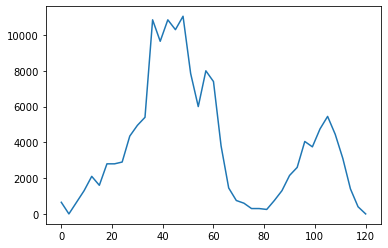

In [19]:
df = ResultWriter.ChargingStationStates
df1 = df.loc[df.ChargingStationID == "chargingStation-1"]
#df1
fig = plt.plot(df1.TotalChargingPower)

In [12]:
df2=ResultWriter.Events
df2 = df2.loc[df2.Event =='ReleaseEvent']
df2.head(10)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
6,18463,ReleaseEvent,chargingStation-1,5270466,,NaN,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300_XFC,18163,18163,91.272571,70.439238,1.087175,83.953903,400.0,NaN
7,18463,ReleaseEvent,chargingStation-1,3256681,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200,18406,18406,59.303395,46.803395,1.059571,55.969269,150.0,NaN
8,18463,ReleaseEvent,chargingStation-1,1545605,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,52.956413,46.664746,0.630780,83.953903,400.0,NaN
16,19063,ReleaseEvent,chargingStation-1,4346132,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18980,18980,96.141403,75.308069,1.145169,83.953903,400.0,NaN
17,19063,ReleaseEvent,chargingStation-1,3629343,,NaN,phev-L1-0-to-50000-LowTech-2035-SUV-PHEV_50,19055,19055,24.787763,12.287763,1.771527,13.992317,150.0,NaN
18,19063,ReleaseEvent,chargingStation-1,2940186,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200_XFC,19119,19422,52.962951,44.754618,0.946286,55.969269,400.0,NaN
34,19363,ReleaseEvent,chargingStation-1,2594333,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200_XFC,19157,19217,63.115963,44.782630,1.127690,55.969269,400.0,NaN
35,19363,ReleaseEvent,chargingStation-1,1506474,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200_XFC,19232,19364,60.120744,44.787411,1.074174,55.969269,400.0,NaN
38,19363,ReleaseEvent,chargingStation-3,645747,,NaN,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300_XFC,19021,19870,73.437178,67.145512,0.874732,83.953903,400.0,NaN
39,19363,ReleaseEvent,chargingStation-3,3378004,,NaN,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_200_XFC,19362,19537,58.325518,44.783851,1.042099,55.969269,400.0,NaN


#### save results

In [14]:
ResultWriter.save()

#### plot results

Text(0.5, 0.98, 'chargingStation-1')

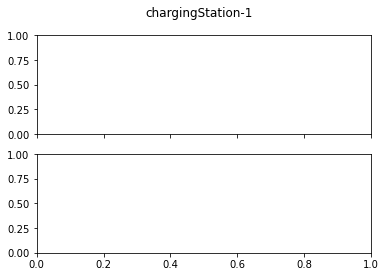

In [15]:
import matplotlib.pyplot as plt
loadDataFromFile = False
plotChargingStation = 0

if loadDataFromFile == True:
    pass

fig, ax = plt.subplots(2,1, sharex=True)
fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
